In [3]:
#chorus config
import librosa
import numpy as np
import math
import pyaudio
fs = 44100
delay_sec = 0.013
depth =0.003
mod_rate = 3.2  #Hz
feedback = 0.3
dry_wet = 0.4
CHUNK = 4096
FORMAT = pyaudio.paFloat32     # audio format (bytes per sample?)
CHANNELS = 1                 # single channel for microphone

delay_samples = np.round(delay_sec * fs)
depth_samples = np.round(depth*fs);

mod_arg = 2*3.1416*mod_rate/fs;
print('done')

done


In [4]:
from ctypes import *
prev_i =c_double(0.0)
mydll = cdll.LoadLibrary(r".\test.dll")
out = np.zeros([CHUNK])
print('done')

done


In [2]:

# pyaudio class instance
p = pyaudio.PyAudio()
# stream object to get data from microphone
stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=fs,
    input=True,
    output=True,
    frames_per_buffer=CHUNK
)

print('stream started')
# for measuring frame rate
frame_count = 0
delay_chnl = np.zeros([CHUNK,1]);
delay_buf = np.zeros([int(delay_samples+depth_samples)])
# prev_i = 0;
mydll = cdll.LoadLibrary(r".\test.dll")
while True:
    # binary data
    data_byte = stream.read(CHUNK)  
    x = np.frombuffer(data_byte, 'Float32').astype('float64');
#     for i in range(len(x)):
#     #   math sin is faster than np sin
#         modulated_sample = depth_samples*math.sin(mod_arg*(i)+prev_i)
#         modulated_sample += (delay_samples-1)
# #       interpolate
#         interp1 =delay_buf[math.floor(modulated_sample)];
# #         interp2 =delay_buf[math.ceil(modulated_sample)];
# #         query_sample = math.modf(modulated_sample)[0] #get decimal part
#         delay_chnl[i] = interp1
#         new_sample= x[i]+interp1*feedback;
#         delay_buf[-1] = new_sample
#         delay_buf = np.roll(delay_buf,1)
#     prev_i = (mod_arg*(i)+prev_i)%(3.1416*2)
#     out = ((1-dry_wet)*x)+(dry_wet*delay_chnl.flatten())

    mydll.chorus(c_void_p(x.ctypes.data),c_void_p(out.ctypes.data),\
                c_void_p(delay_buf.ctypes.data),CHUNK,addressof(prev_i))

    encoded =  out.astype('float32').tobytes()
    
    stream.write(encoded)

stream.stop_stream() # pause audio stream
stream.close() # close audio stream

handle = mydll._handle # obtain the DLL handle
windll.kernel32.FreeLibrary(handle)

NameError: name 'pyaudio' is not defined

In [17]:
import numpy as np
i = np.array([1,2])
out = np.zeros([5])
handle = mydll._handle # obtain the DLL handle

windll.kernel32.FreeLibrary(handle)
print(out)

[0. 0. 0. 0. 0.]


In [62]:
stream.close()
p.terminate()

In [14]:
import numpy as np
z = np.array([])
a = np.array([1,2])
z = np.concatenate((z,a))
delay_buf = np.zeros([11])
print(delay_buf)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


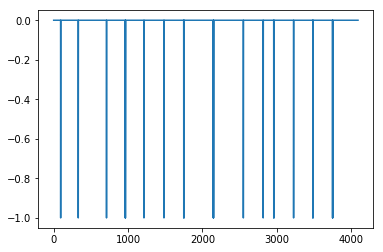

In [31]:
import matplotlib.pyplot as plt
import sounddevice as sd
plt.plot(out)
plt.show()


sd.play(z, fs)

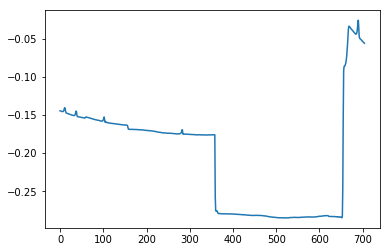

In [48]:
import matplotlib.pyplot as plt
plt.plot(delay_buf)
plt.show()

In [16]:
import pyaudio
import numpy as np

CHUNK = 4096 # number of data points to read at a time
fs = 44100 # time resolution of the recording device (Hz)

p=pyaudio.PyAudio() # start the PyAudio class
stream=p.open(format=pyaudio.paInt16,channels=1,rate=fs,input=True,
              frames_per_buffer=CHUNK) #uses default input device

# create a numpy array holding a single read of audio data
for i in range(10): #to it a few times just to see
    data = np.fromstring(stream.read(CHUNK),dtype=np.int16)
    print(data.shape)

# close the stream gracefully
stream.stop_stream()
stream.close()
p.terminate()

(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


In [15]:
import librosa
data, fs = librosa.load("a.wav",sr=None)
data5 = pitchshift(data,5)

plt.plot(data)
plt.show()
data = data/max(data)
data5 = data5/max(data5)

data = data5
data = 0.3*(data/max(data))
p = pyaudio.PyAudio()
stream = p.open(format = pyaudio.paFloat32, channels = 1, rate = fs, output = True)
stream.write(data.astype(np.float32).tostring())

NameError: name 'pitchshift' is not defined